# Predicting Sequence model using DNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


A sequence plot may have the following properties:
* trend: *upwards or downwards shift in a data set over time*
* seasonality: *A particular repeating characteristic*
* noise: *Any form of change in data not predictable*

Using all of the above, we can create a synthetic series which depends on the time. Below functions are used to do all of the change in properties.The `plot_series` function is to plot the synthetic series. 

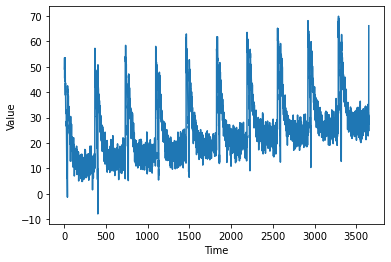

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

Next, we define a windowed dataset. A window would be a small sample of the dataset, which makes the processing of the Dataset much more easier.Each window is of a particular size. The Dataset can also be shuffled and then made it batches, for easier processing.

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Here, the model is having 3 layers, each of which are fully connected. The loss function used is Mean Squared Error. Stochastic gradient descent is the optimizer used with a learning rate of $10^{-6}$. The loss is really high( about 22) and there was no significant increase in performance( Its just 3 Dense Layers, can't expect much ), so it was better not to show the training epochs.

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


Our training data consist of entire series which is present in Dataset.The below code is used to divide the series into sizes of `window_size`. Then, we predict on that and append it into a list called forecast. Likewise, except for the initial window_size, the remaining length of the series is predicted and appended to forecast.

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

We need to check performance of model. For that we separate out the validation set using `forecast[split_time-window_size:]` and then store it in result. Ploting the actual validation set with our forecasted validation set gives an overall performance rating.

In [6]:
forecast = forecast[split_time-window_size:]
print(np.array(forecast)[:, 0, 0])
results = np.array(forecast)[:, 0, 0]

[37.167503 38.904427 35.07452  37.07383  35.258263 36.580406 34.178864
 33.08709  32.634968 34.48276  35.38918  32.549335 32.488068 30.421228
 33.352783 32.013813 33.602795 31.562567 32.21329  31.051474 34.144302
 29.673878 32.40794  28.126123 33.187008 29.02722  29.15366  29.571846
 30.320719 33.296158 30.894266 31.36563  31.872526 30.017729 32.212326
 31.604511 31.167023 27.52423  28.583399 29.476744 31.365705 30.442986
 29.895557 30.853539 29.87324  28.29255  26.577372 28.46703  29.246561
 27.398357 25.81082  27.063168 25.35124  23.830278 25.905716 27.718027
 28.319107 25.123877 29.729652 30.38215  29.310263 26.517984 29.179342
 29.61902  27.442846 27.210712 25.872774 29.73518  27.228237 26.070349
 27.02691  26.043009 24.984715 25.638296 28.729383 28.712248 27.999266
 25.643442 26.903952 28.543497 27.35012  26.765036 27.995817 27.23847
 26.564316 25.537273 24.618132 25.153286 27.898428 25.225582 26.723145
 23.401987 26.681524 26.831532 26.001896 24.53083  26.168118 25.04377
 25.4081

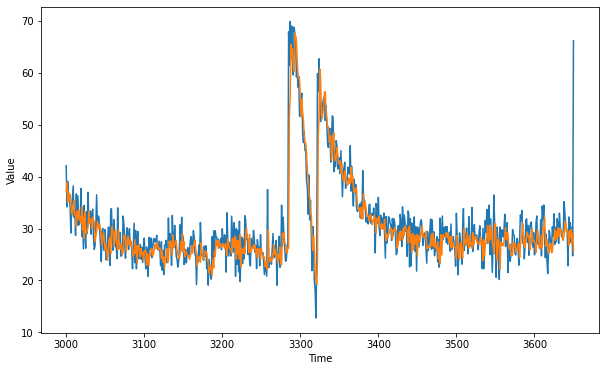

In [7]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Blue indicates validation set and orange indicates predicted validation set.

Finally, we find out the Mean Absolute Error for comapring the 3-Layer DNN with maybe better Networks like RNN.

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0474677